<a href="https://colab.research.google.com/github/VictorEscribano/IPM_GAN/blob/main/Proyecto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DepthGan model to estimate depth from a single image. 
Based on Pix2Pix Architectire


In [1]:
!nvidia-smi

Thu May 18 16:18:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) Data preprocessing

### **Partition of the image directions**

De 346 imagenes, 329 son destinadas al entrenamiento y 17 para testing



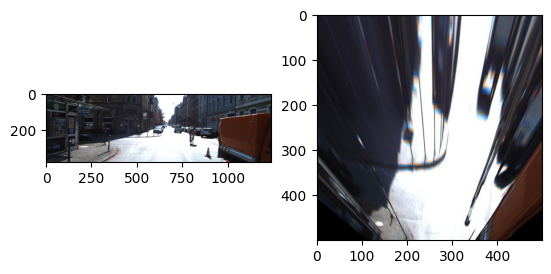


The input image is of size (375, 1242, 3) and target image of size (500, 500, 3).


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

#Ruta raiz
PATH = '/content/drive/MyDrive/Master Robotica/MachineLearning/Final Project/Dataset'

#Ruta datos de entrada
INPATH = PATH + '/all_input/'
#INPATH = PATH + '/input_images/'

#Ruta datos de salida
OUTPATH = PATH + '/all_target/'
#OUTPATH = PATH + '/target_images_jpg/'

#Ruta checkpoints
CKPATH = PATH + '/checkpoints'

#Guardamos el nombre de todas las imagenes de entrada con comando bash
imgurls = !ls -1 '{INPATH}'


#Randomize data order as it is ordered by timestamp
n = len(imgurls) #numero de imagenes del dataset
train_n = round(n * 0.95)
#train_n = round(n * 0.15)

#LIstado randomizado
randurls = np.copy(imgurls)
np.random.shuffle(randurls)

#Particion en train y test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print('De {} imagenes, {} son destinadas al entrenamiento y {} para testing\n'.format(len(imgurls), len(tr_urls), len(ts_urls)))

in_im = plt.imread(INPATH + randurls[0])
tg_im = plt.imread(OUTPATH + randurls[0])

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(in_im)
ax2.imshow(tg_im)
plt.show()

print('\nThe input image is of size {} and target image of size {}.'.format(in_im.shape, tg_im.shape))

### **Load images and preprocessing**

1.   Define resize function
2.   Define normalization function
3.   Augmentation with random Jitter




The input image is of size (128, 128, 3) and target image of size (128, 128, 3).


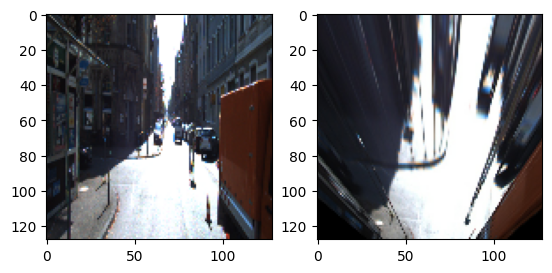

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128

#Reescalar imagenes
def resize(inimg, tgimg, height=IMG_WIDTH, width=IMG_HEIGHT):

  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])

  return inimg, tgimg

#Trabajar en el dominio de 0 a 1
def normalize(inimg, tgimg):

  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  return inimg, tgimg

@tf.function()
def random_jitter(inimg, tgimg):

  inimg, tgimg = resize(inimg, tgimg)
  #print('BEFORE STACK: The input image is of size {} and target image of size {}.\n '.format(inimg.shape, tgimg.shape))

  #Apilamos las dos imagenes.
  stacked_image = tf.stack([inimg, tgimg], axis=0)
  #print('AFTER STACK: The image is of size {}.\n '.format(stacked_image.shape))

  #recortamos la imagen de 286 a 256 con un crop random
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  #recuperamos las imagenes origiales y las desapilamos
  inimg, tgimg = cropped_image[0] , cropped_image[1]

  #print('AFTER CROP: The input image is of size {} and target image of size {}.\n '.format(inimg.shape, tgimg.shape))

  if tf.random.uniform(()) > 0.5:
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg

#cargar las imagenes
def load_image(filename, augment=True):

  #cargamos las imagenes y espacificamos que solo queremos los tres canales RGB para evitar problemas con las imagenes PNG
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[...,:3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + filename)), tf.float32)[...,:3]

  #hacemos el resize pero no estoy seguro si hacerlo porque en el random jitter ya lo hace
  #REVISAR
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)

  inimg, tgimg = normalize(inimg, tgimg)

  return inimg, tgimg


def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)


##### SANITY CHECK TO SEE IF ALL IS OKAY #####
inimg, tgimg = load_train_image(randurls[0])
print('\nThe input image is of size {} and target image of size {}.'.format(inimg.shape, tgimg.shape))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow((inimg + 1 ) / 2)
ax2.imshow((tgimg + 1 ) / 2)
plt.show()



### Load images

(4, 128, 128, 3)


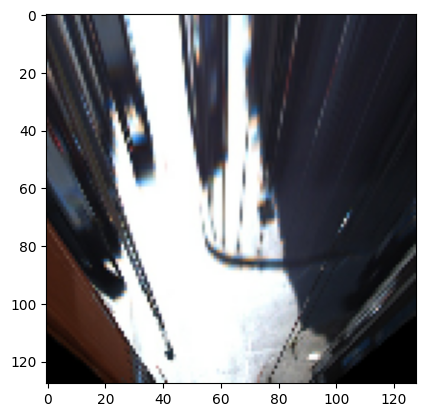

(4, 128, 128, 3)


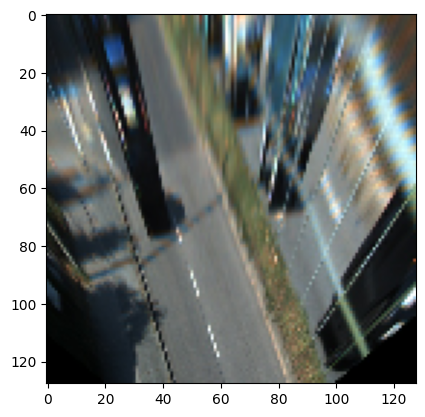

In [5]:
#Con esto generaremos un dataset con un listado de elementos que le digamos
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
#mapea el dataset geneado con la funcion que le digamos para cargar las imagenes
train_dataset = train_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
#Distribuimos los datos en diferentes lotes (Batch). En el paper se especifica batch size = 1
batch = 4
train_dataset = train_dataset.batch(batch)

##### SANITY CHECK TO SEE IF ALL IS OKAY #####
for in_img, tg_img in train_dataset.take(2):
  print(tg_img.shape)
  plt.imshow((tg_img[0,...] + 1 ) / 2)
  plt.show()

#Repetimmos lo mismo con el dataset de test

#Con esto generaremos un dataset con un listado de elementos que le digamos
test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
#mapea el dataset geneado con la funcion que le digamos para cargar las imagenes
test_dataset = test_dataset.map(load_test_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
#Distribuimos los datos en diferentes lotes (Batch). En el paper se especifica batch size = 1
test_dataset = test_dataset.batch(batch)

## 2) Pix2Pix architecture

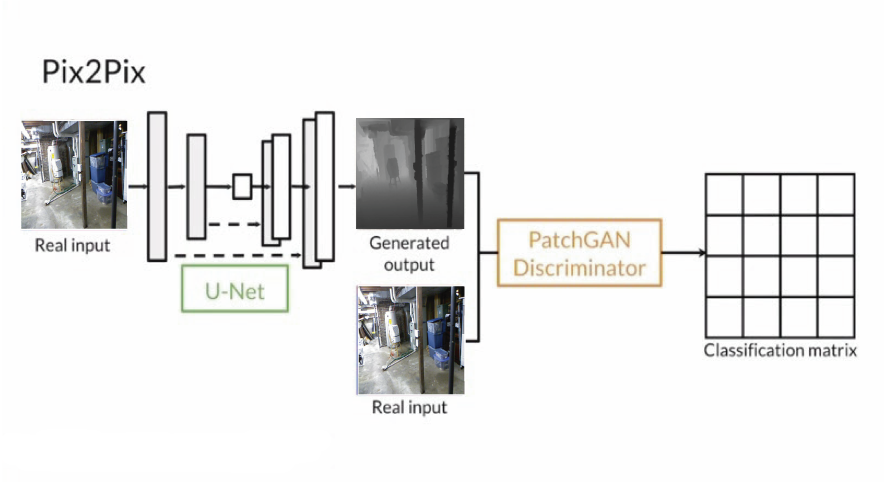

In [6]:
#Library to ✨visualize✨ the nets lately
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 40.6 MB/s eta 0:00:00


### Encoder (Unet Downsample)

In [7]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

#NUMBER OF OUTPUT LAYER IMAGE CHANNELS. 
#If we want the output layer to only have 1 color channel n=1, if generated image is rgb n=3
chnl_num = 3

#encoder
def downsample(filters, apply_batchnorm=True):

  result = Sequential()

  initializer = tf.random_normal_initializer(0, 0.02)

  #Capa convolucional
  result.add(Conv2D(filters,
             kernel_size = 4,
             strides = 2,
             padding = 'same', 
             kernel_initializer=initializer,
             use_bias = not apply_batchnorm))

  if apply_batchnorm:
    # Capa de Batch Normalization
    result.add(BatchNormalization())

  #Capa de activación
  result.add(LeakyReLU())

  return result

##### SANITY CHECK TO SEE IF ALL IS OKAY #####
down_model = downsample(3)
down_result = down_model(tf.expand_dims(inimg, 0))
print (down_result.shape)

(1, 64, 64, 3)


### Decoder (Unet Upsampler)

In [8]:
from tensorflow.python.ops.gen_nn_ops import Conv2DBackpropFilter
#decoder
def upsample(filters, apply_dropout=True):

  result = Sequential()

  initializer = tf.random_normal_initializer(0, 0.02)

  #Capa convolucional
  result.add(Conv2DTranspose(filters,
                             kernel_size = 4,
                             strides = 2,
                             padding = 'same', 
                             kernel_initializer=initializer,
                             use_bias = False))

  # Capa de Batch Normalization
  result.add(BatchNormalization())

  if apply_dropout:
    #Capa de dropout (Desconecta conexiones para regularizar la red)
    result.add(Dropout(0.5))

  #Capa de activación
  result.add(ReLU())

  return result

##### SANITY CHECK TO SEE IF ALL IS OKAY #####
up_model = upsample(3)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)


### UNet (Downsample+Upsample)

(4, 128, 128, 3)


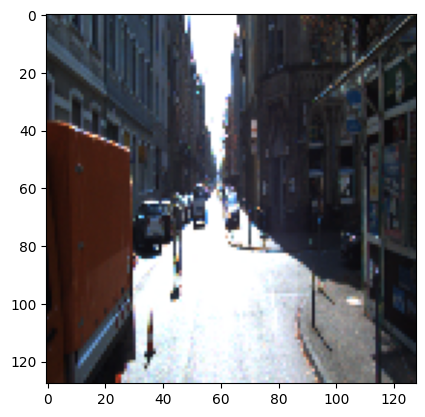

In [13]:
from pyparsing.core import SkipTo
from keras.layers.serialization import activation
def Generator():

  #Pongo 'None' en vez de 256 para dar paso a imagenes de diferentes tamaños
  inputs = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3])

  down_stack = [
    downsample(64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128),  # (batch_size, 64, 64, 128)
    downsample(256),  # (batch_size, 32, 32, 256)
    downsample(512),  # (batch_size, 16, 16, 512)
    downsample(512),  # (batch_size, 8, 8, 512)
    downsample(512),  # (batch_size, 4, 4, 512)
    downsample(512),  # (batch_size, 2, 2, 512)
    # downsample(512),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512),  # (batch_size, 16, 16, 1024)
    upsample(256),  # (batch_size, 32, 32, 512)
    upsample(128),  # (batch_size, 64, 64, 256)
    # upsample(64),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  #El numero de filtros va acorde con el numero de canales en el 
  #caso de querer generar rgb filters=3 si queremos generar escala de grises filters = 1
  #TODO
  last = Conv2DTranspose(filters = chnl_num,
                         kernel_size = 4,
                         strides = 2,
                         padding = 'same',
                         kernel_initializer = initializer, 
                         activation = 'tanh')

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
    
  #Invertimos las capas del codificador excepto la del cuello de botella (penultimo elemento) para luego poder conectar con el decoder
  skips = reversed(skips[:-1])
  
  #decodificador + concatencacion de las skip conections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
  
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

#load an image for testing pourposes
for in_img, tg_img in train_dataset.take(1):
  plt.imshow((in_img[0,...] + 1 ) / 2)
  test_im = (in_img + 1 ) / 2
  print(test_im.shape)
plt.show()


(4, 128, 128, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

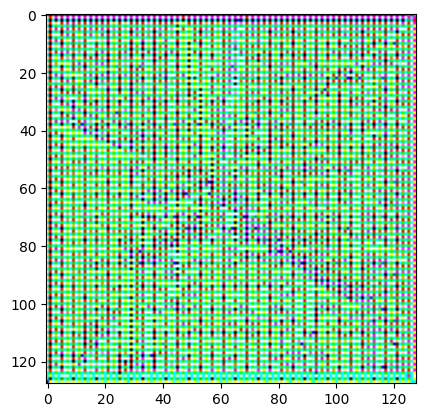

In [14]:
generator = Generator()
#test_im = np.expand_dims(test_im, axis=0); #Ejecutar en caso de que las dimensiones sean [256, 256, 3] en vez de [1, 256, 256, 3]
gen_output = generator(((test_im+1)*255), training=False)
print(gen_output.shape)
plt.imshow(gen_output[0,...])
plt.show


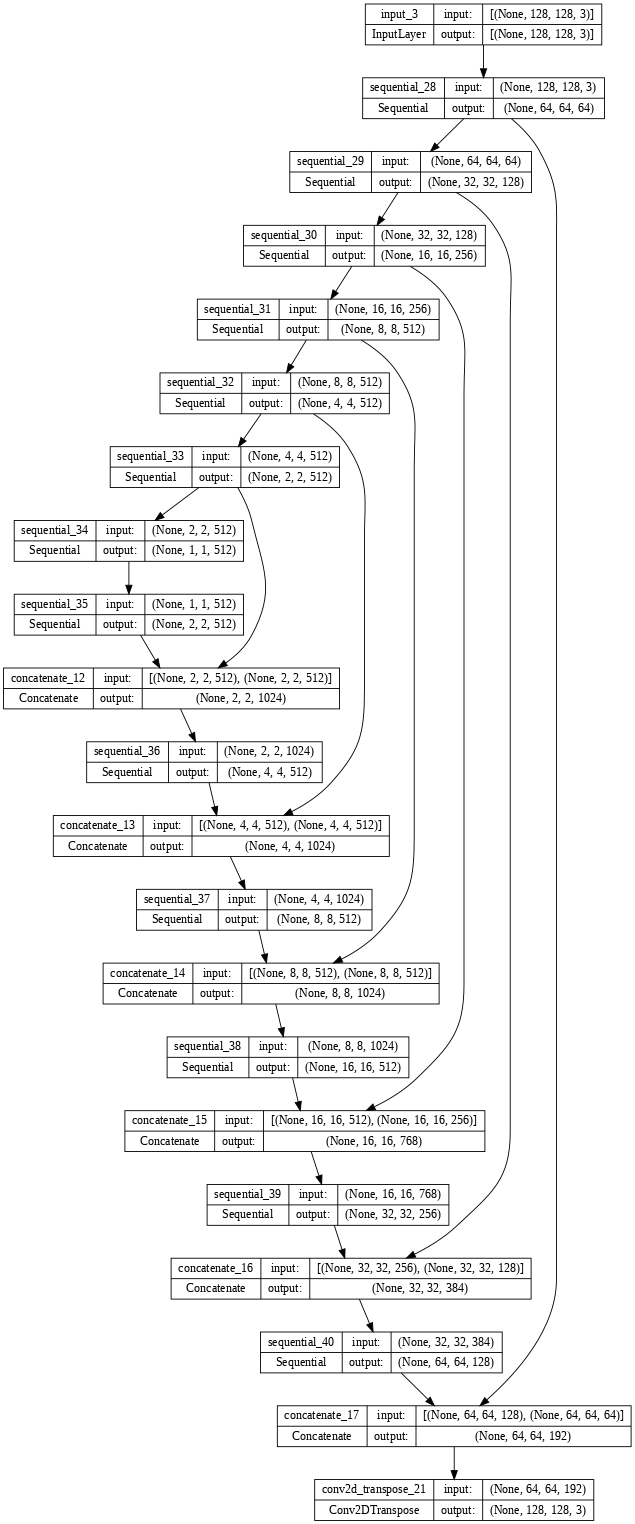

In [15]:
utils.plot_model(generator, show_shapes=True, dpi=64)

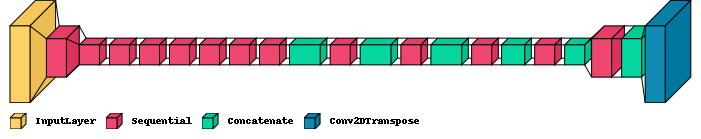

In [16]:
visualkeras.layered_view(Generator(), legend=True, scale_xy=0.6, scale_z=0.03)

### Discriminator (patchGAN)

The paper does not use a CNN as a typical discriminator (0 or 1), it uses a patchGan. Instead of return a 0 or 1, it returns a matrix of values (patches) where the values correspond to more real or fake values of the target image.

(Basically is like a CNN cutted by the end)

In [17]:
def Discriminator():
  # El discriminador debe tener acceso a la imagen original i a la generada, por lo tanto necesita tener 2 inputs
  ini = Input(shape = [IMG_WIDTH, IMG_HEIGHT, 3], name='input_img')
  gen = Input(shape = [IMG_WIDTH, IMG_HEIGHT, chnl_num], name='gener_img')

  con = concatenate([ini, gen])

  initializer = tf.random_normal_initializer(0., 0.02)

  down1 = downsample(64, apply_batchnorm = False)(con)  # (batch_size, 128, 128, 64)
  down2 = downsample(128)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256)(down2)  # (batch_size, 32, 32, 256)
  down4 = downsample(512)(down3)  # (batch_size, 16, 16, 512)

  #aplicamos 1 filtro para que solo haya 1 canal -> valor real o no real para cada pixel
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)
  last = Conv2D(filters = 1,
                         kernel_size = 4,
                         strides = 1,
                         padding = 'same',
                         kernel_initializer = initializer)(down3)
  
  return tf.keras.Model(inputs = [ini, gen], outputs=last)


TensorShape([4, 16, 16, 1])

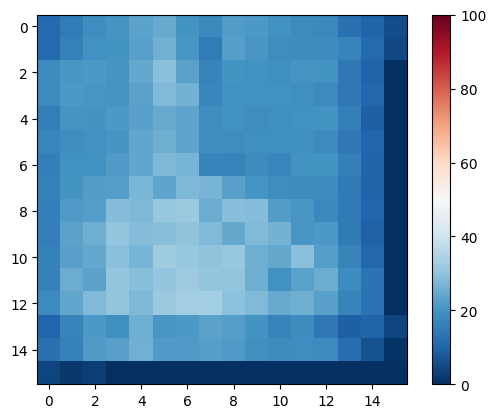

In [18]:
discriminator = Discriminator()
disc_out = discriminator([((test_im+1)*255), gen_output], training = False)
plt.imshow(disc_out[0,...,-1], vmin = 0, vmax = 100, cmap = 'RdBu_r')
plt.colorbar()
disc_out.shape

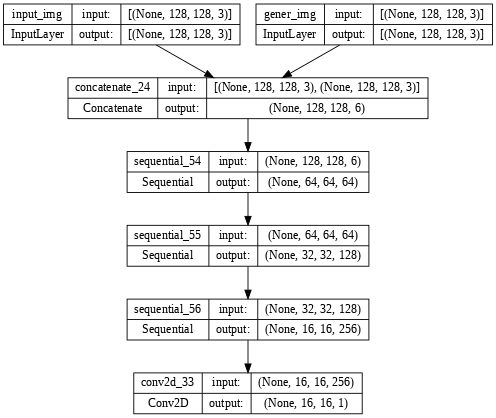

In [19]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

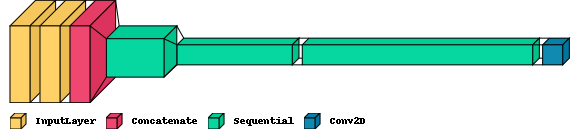

In [20]:
visualkeras.layered_view(Discriminator(), legend=True, scale_xy=0.6, scale_z=0.9)

### Adversial cost function
Basically this will merge the result from the generator and discriminator. And will be the one that makes the comptition between the 2 nets during the training.

In [21]:
#Definir la function de coste con BinaryCrossentropy de keras para calcular la entropia cruzada de cada uno de los pixeles de las imagenes obtenidas
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  # Diferencia entre la imagen real y la generada por el discriminador.
  # El resultado idoneo tendria que decir que todos los pixeles de la imagen son reales (calientes)
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  # Diferencia entre el resultado del discriminador y el generado por el generador
  # En un resultado ideal para el discriminador todos los valores tendrian que ser falsos (frios)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  # Valor que definirá el discriminator loss
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss


In [22]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  # El error adversario es el resultado del discriminador al observar la imagen generada y el resultado esperado (todo unos, caliente)
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Diferencia por pixeles en valor absoluto entre la imagen que queriamos generar y la generada.
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  # El hyperparametro LAMBDA nos permite regular el valor del peso de cada error. El paper recomienda 100.
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss


## 3) Optimizators + checkpoint generator

In [27]:
import os

# Adam optimizator with hyperparameters specified by the original paper -> tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
#Upgrades on https://keras.io/examples/generative/gan_ada/. Here I found some tips to optimize the models
learning_rate_generator = 2e-4
learning_rate_discriminator = 2e-3
beta_1 = 0.5
beta_2 = 0.999

generator_optimizer = tf.keras.optimizers.Adam(learning_rate_generator, beta_1=beta_1, beta_2=beta_2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate_discriminator, beta_1=beta_1, beta_2=beta_2)

# Guardamos estados de la ejecucion del entrenamiento
# Guardamos el estado de los optimizadores y de los generadores y discriminadores
checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### Codigo para restaurar el ultimo checkpoint del entrenamiento ####
#checkpoint.restore(tf.train.latest_checkpoint(CKPATH))

## 4) Generate images function
Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and voila!

Note: The `training=True` is intentional here since you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [28]:
def generate_images(model, test_input, tar, name, save_filename = False, display_imgs = True):
  prediction = model(test_input, training=True)

  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      if i==2:
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
      else:
        plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
      if save_filename:
        plt.savefig(PATH + '/output/' + name + '.jpg', dpi=300)
  plt.show()

In [29]:
def generate_test_images(model, test_input, tar, name, save_filename = False, display_imgs = True):
  test_input= resize(test_input, None)

  prediction = model(test_input, training=True)

  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      if i==2:
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
      else:
        plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    if save_filename:
      #tf.keras.preprocessing.image.save_img(PATH + '/output/' + name + '.jpg', prediction[0, ...])
      plt.savefig(PATH + '/Output_test_results/' + name + '.jpg', dpi=300)
  plt.show()

In [30]:
def evaluate(model, test_input, name, save_filename = False, display_imgs = True):
  test_input= resize(test_input, test_input)
  test_input = test_input[0]
  prediction = model(test_input, training=True)

  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  if display_imgs:
    for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      if i==1:
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
      else:
        plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    if save_filename:
      #tf.keras.preprocessing.image.save_img(PATH + '/output/' + name + '.jpg', prediction[0, ...])
      plt.savefig(PATH + '/Output_test_results/' + name + '.jpg', dpi=300)
  plt.show()

  return prediction[0], test_input

## 5) Train rutine

In [32]:
from IPython.display import clear_output
from keras.models import load_model


@tf.function
def train_step(input_image, target):
  #convertimos el target a escala de grises:
  if chnl_num == 1:
    target = tf.image.rgb_to_grayscale(target)

  # Definimos los objetos: Gradian tape del generador y del discriminador
  # El gradient tape es un sistema de autodiferenciacion por lo tanto calcula las derivadas parciales de todas las operaciones registradas
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Generador genera imagen
    gen_output = generator(input_image, training=True)

    # Discriminador evalua la imagen generada y l areal
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    # Computo de las funciones de coste del generador
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    # Computo de las funciones de coste del discriminador
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculamos ls gradientes del generador/discriminador (Registar operaciones y calcula gradientes)
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    # Optimizamos los parametros en function de los gradientes calculados
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    imgi = 0
    for input_image, target in dataset:
      print('epoch ' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))
      imgi += 1
      train_step(input_image, target)
      clear_output(wait=True)

    for inp, tar in test_dataset.take(10):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), save_filename = True, display_imgs = True)

    #guardando checkpoint cada x epochs
    x =1
    if (epoch + 1) % x == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      # generator.save(PATH + '/models/generator_' + str(epoch) +'.h5')


In [35]:

#### Codigo para restaurar el ultimo checkpoint del entrenamiento ####
# checkpoint.restore(tf.train.latest_checkpoint(CKPATH))

In [ ]:
train(train_dataset, 100)

epoch 41 - train: 52/329


## 6) Save/Load Model

Save

In [ ]:
generator.save(PATH + '/models/generator_final.h5')

Load

In [ ]:
model = load_model(PATH + '/models/generator_80_epochs_A100.h5')

## 7) Testing

In [ ]:
i = 0
for inp, tar in test_dataset.take(10):
  name = 'test_' + str(i)
  generate_images(model, inp, tar, name , save_filename = True, display_imgs = True)
  i += 1